In [21]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import albumentations as A
import itertools

In [215]:
images=sio.loadmat('DS.mat')
images=images['DS']
tr_images=images[:800,:,:,:]
test_images=images[800:,:,:,:]
labels=sio.loadmat('labels.mat')
labels=labels['par']
tr_labels=labels[:800,:]
test_labels=labels[800:,:]
tr_images=np.moveaxis(tr_images,-1,1) #Change the format of tensor since in torch channels are in the second axis.
test_images=np.moveaxis(test_images,-1,1)
print(np.shape(tr_images),np.shape(test_images))
print(np.shape(tr_labels),np.shape(test_labels))

(800, 2, 200, 200) (200, 2, 200, 200)
(800, 6) (200, 6)


In [23]:
class TF_image_dataset(Dataset):
  def __init__(self, in_dataset, out_dataset, transform=None):
    self.in_dataset=torch.Tensor(in_dataset)
    self.out_dataset=torch.Tensor(out_dataset)
    self.transfrom=transform
  def __len__(self):
    return self.in_dataset.size(0)

  def __getitem__(self,index):
    x=self.in_dataset[index]
    x=self.transfrom(x)
    y=self.out_dataset[index]
    return x, y
    
def get_loader(in_dataset, out_dataset, batch_size,transform,num_workers, pin_memory=True):
  tr_ds=TF_image_dataset(
    in_dataset=in_dataset,
    out_dataset=out_dataset,
    transform=transform,
    )
  train_loader=DataLoader(tr_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

  return train_loader



torch.Size([15, 2, 200, 200])
tensor(1.1335) tensor(-0.7968)
tensor(0.1436) tensor(0.1436)
tensor(1.3166) tensor(-0.7619)
tensor(0.1417) tensor(0.1417)
tensor(1.2068) tensor(-0.9014)
tensor(0.1694) tensor(0.1694)
tensor(1.3224) tensor(-0.7984)
tensor(0.1733) tensor(0.1733)
tensor(1.1582) tensor(-1.0807)
tensor(0.1363) tensor(0.1363)
tensor(1.2890) tensor(-0.9396)
tensor(0.0929) tensor(0.0929)
tensor(1.0467) tensor(-1.0741)
tensor(-0.0065) tensor(-0.0065)
tensor(1.0028) tensor(-0.9412)
tensor(0.0871) tensor(0.0871)
tensor(1.4875) tensor(-0.8826)
tensor(0.0732) tensor(0.0732)
tensor(1.1795) tensor(-0.7533)
tensor(0.1965) tensor(0.1965)
tensor(1.0990) tensor(-0.9031)
tensor(0.0918) tensor(0.0918)
tensor(1.4641) tensor(-1.0036)
tensor(0.2011) tensor(0.2011)
tensor(1.5671) tensor(-0.9579)
tensor(0.1905) tensor(0.1905)
tensor(0.9392) tensor(-0.9549)
tensor(0.0047) tensor(0.0047)
tensor(1.0838) tensor(-1.1430)
tensor(0.0118) tensor(0.0118)


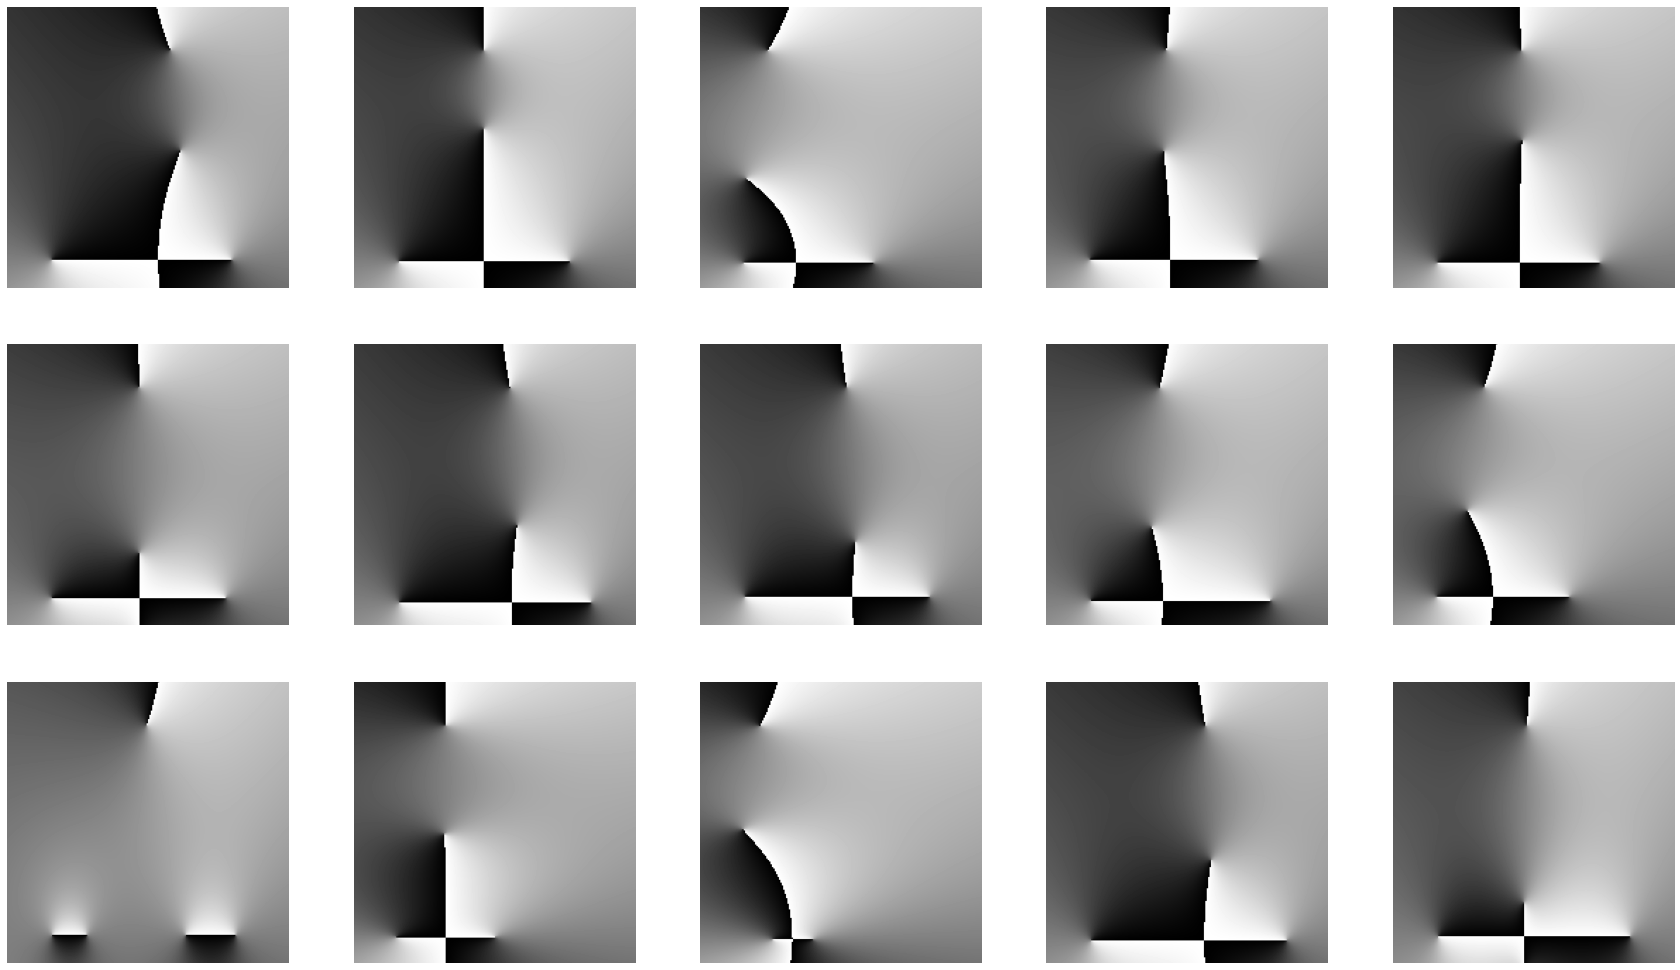

In [216]:
BATCH_SIZE=15
NUM_WORKERS=0
PIN_MEMORY=True
TRANSFORM = transforms.Compose(
            [
            transforms.Normalize(mean=[0, 0],std=[50 ,3.14])]
            )

train_loader=get_loader(tr_images,tr_labels,BATCH_SIZE,TRANSFORM,NUM_WORKERS,PIN_MEMORY)
test_loader=get_loader(test_images,test_labels,200,TRANSFORM,NUM_WORKERS,PIN_MEMORY)
imag, l = next(iter(train_loader))
print(imag.shape)

plt.figure(figsize=(30,30))
for i in range(BATCH_SIZE):
    ax=plt.subplot(5,5,i+1)
    plt.imshow(imag[i,1,:,:],cmap='gray')
    plt.axis('off')
    print(torch.max(imag[i,0,:,:]),torch.min(imag[i,0,:,:]))
    print(torch.mean(imag[i,0,:,:]),torch.mean(imag[i,0,:,:]))
   


In [217]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # inputsize--> N, 2, 200, 200
        self.encoder=nn.Sequential(
            nn.Conv2d(2, 8, 10, stride=5), # --> N, 8, 39, 39
            nn.ReLU(),
            nn.Conv2d(8, 16, 5, stride=2), # --> N, 16, 18, 18
            nn.ReLU(),
            nn.Conv2d(16, 32, 5),# --> N, 32, 14, 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 14)# --> N, 64, 1, 1         
        )
        self.decoder=nn.Sequential(
            nn.ConvTranspose2d(64,32,14),# --> N, 32, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,5),# --> N, 16, 18, 18
            nn.ReLU(),
            nn.ConvTranspose2d(16,8,10,stride=3), # --> N, 8, 61, 61
            nn.ReLU(),
            nn.ConvTranspose2d(8,2,20, stride=3), #--> N, 8, 101, 101
            nn.Tanh()
        )
    def forward(self,x):
        encoded=self.encoder(x)
        decoded=self.decoder(encoded)
        return decoded
        

In [218]:
model=Autoencoder()
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(), lr=1e-3)

In [219]:
num_epochs=5
for epoch in range(num_epochs):
    for (img, _) in train_loader:
        recon=model(img)
        loss=criterion(recon,img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')        

Epoch:1, Loss:0.1032
Epoch:2, Loss:0.0250
Epoch:3, Loss:0.0223
Epoch:4, Loss:0.0187
Epoch:5, Loss:0.0166


In [220]:
out=[]
for (img, _) in train_loader:
    recon=model(img)
    out.append((img,recon))

In [221]:
print(type(img),type(recon))
print(img.size(),recon.size())

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([5, 2, 200, 200]) torch.Size([5, 2, 200, 200])


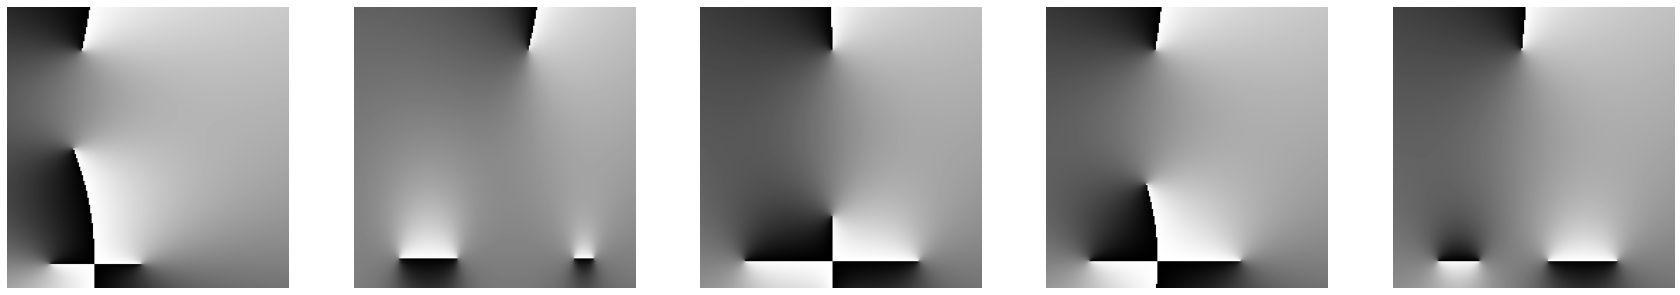

In [222]:
plt.figure(figsize=(30,30))
for i in range(5):
    ax=plt.subplot(5,5,i+1)
    plt.imshow(img.numpy()[i,1,:,:],cmap='gray')
    plt.axis('off')




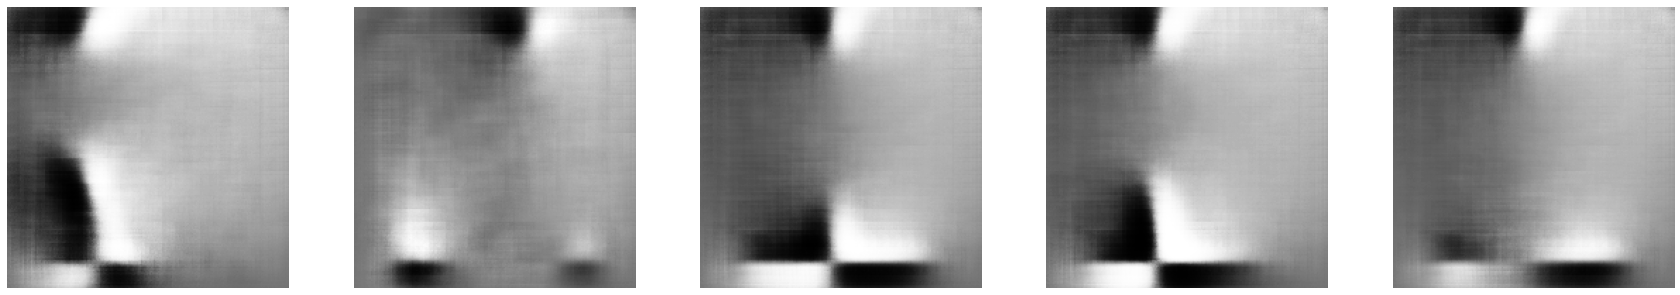

In [223]:
#recon=recon.detach().numpy()
plt.figure(figsize=(30,30))
for i in range(5):
    ax=plt.subplot(5,5,i+1)
    plt.imshow(recon.detach().numpy()[i,1,:,:],cmap='gray')
    plt.axis('off')

In [243]:
x_FC, y_FC=[], []

for (img, L) in train_loader:
    latent=model.encoder(img)
    latent=latent.squeeze()
    x_FC.append(latent)
    y_FC.append(L)

x_FC=torch.cat(x_FC,axis=0)
x_FC=x_FC.detach()
y_FC=torch.cat(y_FC,axis=0)

test_x_FC, test_y_FC=[], []

for (img, L) in test_loader:
    latent=model.encoder(img)
    latent=latent.squeeze()
    test_x_FC.append(latent)
    test_y_FC.append(L)

test_x_FC=torch.cat(test_x_FC,axis=0)
test_x_FC=test_x_FC.detach()
test_y_FC=torch.cat(test_y_FC,axis=0)

In [244]:
class FC (nn.Module):
    def __init__(self):
        super().__init__()
        self.NN=nn.Sequential(
                    nn.Linear(64,32),
                    nn.Sigmoid(),
                    nn.Linear(32,16),
                    nn.Sigmoid(),
                    nn.Linear(16,6)
                )
    def forward(self,x):
        
        return self.NN(x)



In [245]:
model2=FC()
criterion2=nn.MSELoss()
optimizer2=optim.Adam(model2.parameters(), lr=1e-3)


print(x_FC.size())

num_epochs=10000
for epoch in range(num_epochs):

    pred=model2(x_FC)
    loss=criterion2(pred,y_FC)
    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')        


torch.Size([800, 64])
Epoch:1, Loss:3.8298
Epoch:2, Loss:3.7661
Epoch:3, Loss:3.7036
Epoch:4, Loss:3.6423
Epoch:5, Loss:3.5824
Epoch:6, Loss:3.5240
Epoch:7, Loss:3.4671
Epoch:8, Loss:3.4116
Epoch:9, Loss:3.3578
Epoch:10, Loss:3.3054
Epoch:11, Loss:3.2546
Epoch:12, Loss:3.2051
Epoch:13, Loss:3.1569
Epoch:14, Loss:3.1099
Epoch:15, Loss:3.0641
Epoch:16, Loss:3.0193
Epoch:17, Loss:2.9754
Epoch:18, Loss:2.9325
Epoch:19, Loss:2.8904
Epoch:20, Loss:2.8491
Epoch:21, Loss:2.8085
Epoch:22, Loss:2.7687
Epoch:23, Loss:2.7295
Epoch:24, Loss:2.6911
Epoch:25, Loss:2.6532
Epoch:26, Loss:2.6160
Epoch:27, Loss:2.5794
Epoch:28, Loss:2.5434
Epoch:29, Loss:2.5079
Epoch:30, Loss:2.4730
Epoch:31, Loss:2.4387
Epoch:32, Loss:2.4049
Epoch:33, Loss:2.3716
Epoch:34, Loss:2.3388
Epoch:35, Loss:2.3065
Epoch:36, Loss:2.2747
Epoch:37, Loss:2.2434
Epoch:38, Loss:2.2125
Epoch:39, Loss:2.1821
Epoch:40, Loss:2.1520
Epoch:41, Loss:2.1224
Epoch:42, Loss:2.0932
Epoch:43, Loss:2.0644
Epoch:44, Loss:2.0360
Epoch:45, Loss:2.00

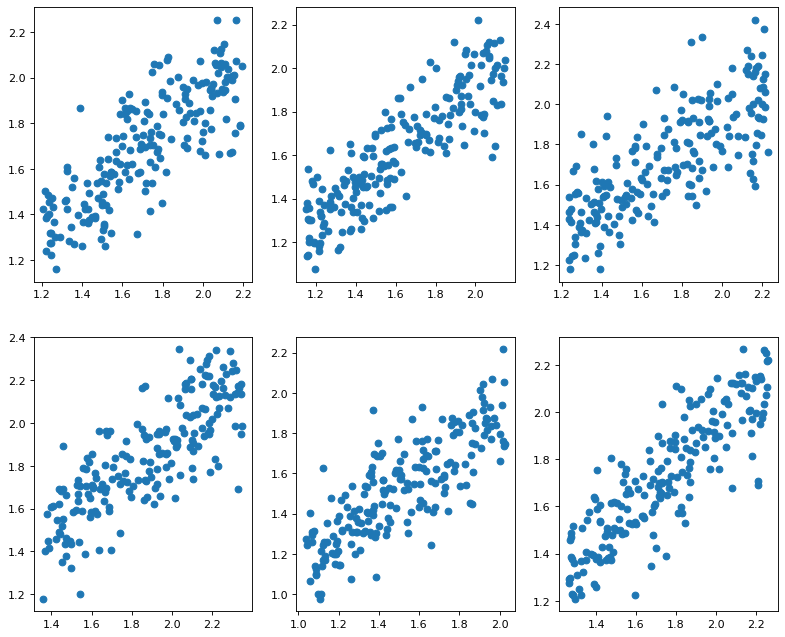

In [246]:

pred=model2(test_x_FC)

plt.figure(figsize=(12, 10), dpi=80)
for i in range (6):
    plt.subplot(2,3,i+1)
    plt.scatter(test_y_FC.numpy()[:,i],pred.detach().numpy()[:,i])




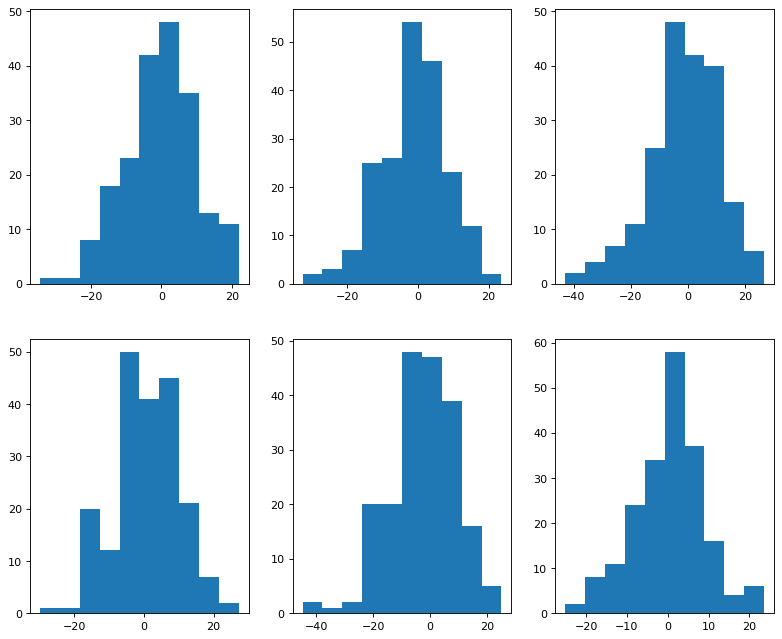

In [248]:
plt.figure(figsize=(12, 10), dpi=80)
for i in range (6):
    plt.subplot(2,3,i+1)
    plt.hist((test_y_FC.numpy()[:,i]-pred.detach().numpy()[:,i])/test_y_FC.numpy()[:,i]*100)